C:\Users\HP\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\HP\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\HP\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Output directory 'C:\Users\HP\Desktop\content\output' already exists. Skipping directory creation.
Output directory 'C:\Users\HP\Desktop\content\output\fused_avg' already exists. Skipping directory creation.
Output directory 'C:\Users\HP\Desktop\content\output\fused_pyramid' already exists. Skipping directory creation.
Output directory 'C:\Users\HP\Desktop\content\output\fused_wavelet' already exists. Skipping directory creation.


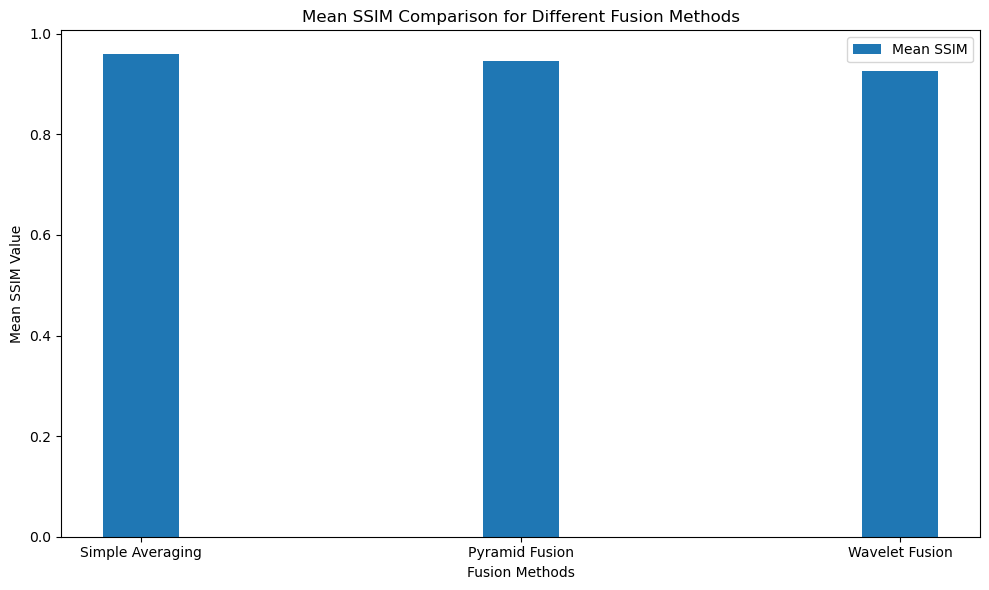

In [1]:
import os
import zipfile
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim

# Function to load and preprocess images
def preprocess_images(image_paths):
    images = []
    for path in image_paths:
        # Load image in RGB format
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"Image at {path} could not be loaded.")

        # Normalize the image to range [0, 1]
        normalized_img = img / 255.0

        images.append(normalized_img)

    return images

# Simple Averaging Fusion
def simple_averaging_fusion(img1, img2):
    fused_img = cv2.addWeighted(img1, 0.5, img2, 0.5, 0)
    return fused_img

# Pyramid-based Fusion using Gaussian and Laplacian pyramids
def pyramid_fusion(img1, img2, levels=3):
    gp1 = [img1]
    gp2 = [img2]
    #Gaussian pyramid
    for i in range(levels):
        img1 = cv2.pyrDown(img1)
        img2 = cv2.pyrDown(img2)
        gp1.append(img1)
        gp2.append(img2)

    lp1 = [gp1[-1]]
    lp2 = [gp2[-1]]
    #Laplacian Methods
    for i in range(levels, 0, -1):
        GE1 = cv2.pyrUp(gp1[i])
        GE2 = cv2.pyrUp(gp2[i])
        GE1 = cv2.resize(GE1, gp1[i-1].shape[:2][::-1])
        GE2 = cv2.resize(GE2, gp2[i-1].shape[:2][::-1])
        L1 = cv2.subtract(gp1[i-1], GE1)
        L2 = cv2.subtract(gp2[i-1], GE2)
        lp1.append(L1)
        lp2.append(L2)

    LS = []
    for l1, l2 in zip(lp1, lp2):
        LS.append(cv2.addWeighted(l1, 0.5, l2, 0.5, 0))
    #reconstructing
    fused_img = LS[0]
    for i in range(1, levels+1):
        fused_img = cv2.pyrUp(fused_img)
        LS_resized = cv2.resize(LS[i], fused_img.shape[:2][::-1])
        fused_img = cv2.add(fused_img, LS_resized)

    fused_img = cv2.resize(fused_img, gp1[0].shape[:2][::-1])
    return fused_img

# Wavelet-based Fusion
def wavelet_fusion(img1, img2, wavelet='db1'):
    fused_channels = []

    for channel in range(img1.shape[2]):
        coeffs1 = pywt.dwt2(img1[:,:,channel], wavelet)
        coeffs2 = pywt.dwt2(img2[:,:,channel], wavelet)

        cA = (coeffs1[0] + coeffs2[0]) / 2
        cH = np.maximum(coeffs1[1][0], coeffs2[1][0])
        cV = np.maximum(coeffs1[1][1], coeffs2[1][1])
        cD = np.maximum(coeffs1[1][2], coeffs2[1][2])

        fused_channel = pywt.idwt2((cA, (cH, cV, cD)), wavelet)
        fused_channels.append(fused_channel)

    fused_img = np.stack(fused_channels, axis=-1)
    fused_img = cv2.resize(fused_img, img1.shape[:2][::-1])
    fused_img = np.clip(fused_img, 0, 1)  # Ensure values are within valid range
    return fused_img

# Function to load and return fused images along with saving them
def save_fused_images(img1, img2, output_dir, f_v, f_p, f_w, folder_name):
    avg_path = os.path.join(f_v, f"{folder_name}_fused_avg.png")
    pyramid_path = os.path.join(f_p, f"{folder_name}_fused_pyramid.png")
    wavelet_path = os.path.join(f_w, f"{folder_name}_fused_wavelet.png")

    fused_img_avg = simple_averaging_fusion(img1, img2)
    fused_img_pyramid = pyramid_fusion(img1, img2)
    fused_img_wavelet = wavelet_fusion(img1, img2)

    cv2.imwrite(avg_path, (fused_img_avg * 255).astype(np.uint8))
    cv2.imwrite(pyramid_path, (fused_img_pyramid * 255).astype(np.uint8))
    cv2.imwrite(wavelet_path, (fused_img_wavelet * 255).astype(np.uint8))

    return fused_img_avg, fused_img_pyramid, fused_img_wavelet

# Function to extract SIFT keypoints and descriptors
def extract_sift_features(image):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

# Function to perform feature matching using FLANN
def feature_matching(img1, img2):
    keypoints1, descriptors1 = extract_sift_features(img1)
    keypoints2, descriptors2 = extract_sift_features(img2)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    return len(good_matches)

# Main function to iterate through the directory and fuse images
def fuse_images_in_directory(base_dir, output_dir, f_v, f_p, f_w):
    if os.path.exists(output_dir):
        print(f"Output directory '{output_dir}' already exists. Skipping directory creation.")
    else:
        os.makedirs(output_dir, exist_ok=True)
    if os.path.exists(f_v):
        print(f"Output directory '{f_v}' already exists. Skipping directory creation.")
    else:
        os.makedirs(f_v, exist_ok=True)
    if os.path.exists(f_p):
        print(f"Output directory '{f_p}' already exists. Skipping directory creation.")
    else:
        os.makedirs(f_p, exist_ok=True)
    if os.path.exists(f_w):
        print(f"Output directory '{f_w}' already exists. Skipping directory creation.")
    else:
        os.makedirs(f_w, exist_ok=True)

    ssim_avg_values = []
    ssim_pyramid_values = []
    ssim_wavelet_values = []

    sift_matches_avg = []
    sift_matches_pyramid = []
    sift_matches_wavelet = []

    feature_matching_data = []

    for root, dirs, files in os.walk(base_dir):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            image_files = [f for f in os.listdir(dir_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            if len(image_files) == 2:
                image_paths = [os.path.join(dir_path, img) for img in image_files]
                images = preprocess_images(image_paths)

                fused_img_avg, fused_img_pyramid, fused_img_wavelet = save_fused_images(images[0], images[1], output_dir, f_v, f_p, f_w, dir_name)

                # Calculate SSIM for each channel and then average
                ssim_avg = np.mean([compare_ssim(images[0][:,:,c], fused_img_avg[:,:,c], data_range=fused_img_avg[:,:,c].max() - fused_img_avg[:,:,c].min()) for c in range(3)])
                ssim_pyramid = np.mean([compare_ssim(images[0][:,:,c], fused_img_pyramid[:,:,c], data_range=fused_img_pyramid[:,:,c].max() - fused_img_pyramid[:,:,c].min()) for c in range(3)])
                ssim_wavelet = np.mean([compare_ssim(images[0][:,:,c], fused_img_wavelet[:,:,c], data_range=fused_img_wavelet[:,:,c].max() - fused_img_wavelet[:,:,c].min()) for c in range(3)])

                ssim_avg_values.append(ssim_avg)
                ssim_pyramid_values.append(ssim_pyramid)
                ssim_wavelet_values.append(ssim_wavelet)

                matches_avg = feature_matching(images[0], fused_img_avg)
                matches_pyramid = feature_matching(images[0], fused_img_pyramid)
                matches_wavelet = feature_matching(images[0], fused_img_wavelet)

                sift_matches_avg.append(matches_avg)
                sift_matches_pyramid.append(matches_pyramid)
                sift_matches_wavelet.append(matches_wavelet)

                feature_matching_data.append({
                    "pair": dir_name,
                    "matches_avg": matches_avg,
                    "matches_pyramid": matches_pyramid,
                    "matches_wavelet": matches_wavelet,
                    "ssim_avg": ssim_avg,
                    "ssim_pyramid": ssim_pyramid,
                    "ssim_wavelet": ssim_wavelet
                })

    with open(os.path.join(output_dir, 'ssim_values.txt'), 'w') as f_ssim:
        for data in feature_matching_data:
            f_ssim.write(f"Image Pair: {data['pair']}\n")
            f_ssim.write(f"  SSIM - Simple Averaging: {data['ssim_avg']}\n")
            f_ssim.write(f"  SSIM - Pyramid Fusion: {data['ssim_pyramid']}\n")
            f_ssim.write(f"  SSIM - Wavelet Fusion: {data['ssim_wavelet']}\n")
            f_ssim.write("\n")

    with open(os.path.join(output_dir, 'feature_matching.txt'), 'w') as f_matches:
        for data in feature_matching_data:
            f_matches.write(f"Image Pair: {data['pair']}\n")
            f_matches.write(f"  Matches - Simple Averaging: {data['matches_avg']}\n")
            f_matches.write(f"  Matches - Pyramid Fusion: {data['matches_pyramid']}\n")
            f_matches.write(f"  Matches - Wavelet Fusion: {data['matches_wavelet']}\n")
            f_matches.write("\n")

    plt.figure(figsize=(10, 6))
    methods = ['Simple Averaging', 'Pyramid Fusion', 'Wavelet Fusion']
    x_pos = np.arange(len(methods))
    ssim_values = [ssim_avg_values, ssim_pyramid_values, ssim_wavelet_values]

    mean_ssim_values = [np.mean(values) for values in ssim_values]

    plt.bar(x_pos, mean_ssim_values, width=0.2, label='Mean SSIM')

    plt.xlabel('Fusion Methods')
    plt.ylabel('Mean SSIM Value')
    plt.title('Mean SSIM Comparison for Different Fusion Methods')
    plt.xticks(x_pos, methods)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Paste your actual unzipped input folder path here
input_folder_path = r"C:\Users\HP\Desktop\content\input"  # Example path on Windows

# Output directories (can stay the same or adjust as needed)
output_directory = r"C:\Users\HP\Desktop\content\output"
fused_avg_directory = os.path.join(output_directory, "fused_avg")
fused_pyramid_directory = os.path.join(output_directory, "fused_pyramid")
fused_wavelet_directory = os.path.join(output_directory, "fused_wavelet")

# Run fusion directly from the input folder
fuse_images_in_directory(input_folder_path, output_directory, fused_avg_directory, fused_pyramid_directory, fused_wavelet_directory)